In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

In [ ]:
# =============================================================================
# 1. LOAD DATASETS
# =============================================================================

# Check if files exist
fear_greed_file = "csv_files/fear_greed_index.csv"
traders_file = "csv_files/historical_data.csv"

# Load datasets
fear_greed = pd.read_csv(fear_greed_file)
traders = pd.read_csv(traders_file)

In [125]:
print("Fear/Greed shape:", fear_greed.shape)
print("Traders shape:", traders.shape)

Fear/Greed shape: (2644, 4)
Traders shape: (211224, 16)


In [126]:
print("\nFear/Greed columns:", fear_greed.columns.tolist())
print("Traders columns:", traders.columns.tolist())


Fear/Greed columns: ['timestamp', 'value', 'classification', 'date']
Traders columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


In [127]:
print("\nFear/Greed sample:")
print(fear_greed.head(3))
print("\nTraders sample:")
print(traders.head(3))


Fear/Greed sample:
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03

Traders sample:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   
1         0

In [128]:
# =============================================================================
# 2. CLEAN FEAR/GREED DATA
# =============================================================================
# Convert timestamps to datetime (handle different formats)
fear_greed['timestamp'] = pd.to_datetime(fear_greed['timestamp'], unit='s', errors='coerce')
if 'date' in fear_greed.columns:
    fear_greed['date'] = pd.to_datetime(fear_greed['date'], errors='coerce')

# Map sentiment to numeric (0-4 scale)
sentiment_map = {
    'Extreme Fear': 0, 'Fear': 1, 'Neutral': 2, 
    'Greed': 3, 'Extreme Greed': 4
}
fear_greed['sentiment_numeric'] = fear_greed['classification'].map(sentiment_map)

# Get latest sentiment per day
if 'date' in fear_greed.columns:
    sentiment_daily = fear_greed.groupby('date').last().reset_index()
    sentiment_daily = sentiment_daily[['date', 'value', 'classification', 'sentiment_numeric']].dropna()
else:
    fear_greed['date'] = fear_greed['timestamp'].dt.date
    sentiment_daily = fear_greed.groupby('date').last().reset_index()
    sentiment_daily = sentiment_daily[['date', 'value', 'classification', 'sentiment_numeric']].dropna()

print(f"Daily sentiment shape: {sentiment_daily.shape}")
print("Sentiment distribution:")
print(sentiment_daily['classification'].value_counts())

Daily sentiment shape: (2644, 4)
Sentiment distribution:
classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64


In [ ]:
# =============================================================================
# 3. CLEAN TRADER DATA
# =============================================================================
# Standardize column names first
column_mapping = {
    'Account': 'account',
    'Coin': 'symbol',
    'Execution Price': 'execution_price',
    'Size Tokens': 'size_tokens',
    'Size USD': 'size_usd',
    'Closed PnL': 'closed_pnl',
    'Timestamp IST': 'timestamp_ist',
    'Start Position': 'start_position',
    'Direction': 'direction',
    'Side': 'side',
    'Fee': 'fee',
    'closedPnL': 'closed_pnl'  # Handle camelCase
}

traders_renamed = traders.rename(columns=column_mapping)

# Detect time column
possible_time_cols = [c for c in traders_renamed.columns if 'time' in c.lower() or 'timestamp' in c.lower()]
print("Detected time-like columns:", possible_time_cols)

if len(possible_time_cols) == 0:
    raise ValueError("No time/timestamp column found!")

# Pick the most detailed timestamp column
time_col = sorted(possible_time_cols, key=lambda c: traders_renamed[c].nunique(), reverse=True)[0]
print("Using time column:", time_col)

# Convert to datetime
traders_renamed['time'] = pd.to_datetime(traders_renamed[time_col], errors='coerce')
traders_renamed['date'] = traders_renamed['time'].dt.date

# Keep relevant columns (only those that exist)
key_cols = ['account', 'symbol', 'execution_price', 'size_tokens', 'size_usd', 
            'side', 'direction', 'closed_pnl', 'time', 'date']
existing_cols = [c for c in key_cols if c in traders_renamed.columns]
print("Using columns:", existing_cols)

traders_clean = traders_renamed[existing_cols].copy()
print("Initial clean shape:", traders_clean.shape)

# Filter valid data
if 'execution_price' in traders_clean.columns:
    traders_clean = traders_clean[traders_clean['execution_price'] > 0]
if 'closed_pnl' in traders_clean:
    traders_clean = traders_clean[traders_clean['closed_pnl'].notna()]
print("After basic filtering:", traders_clean.shape)

# Remove outliers
if 'closed_pnl' in traders_clean.columns and len(traders_clean) > 0:
    pnl_std = traders_clean['closed_pnl'].std()
    traders_clean = traders_clean[np.abs(traders_clean['closed_pnl']) <= 3 * pnl_std]
print("Final clean shape:", traders_clean.shape)

Detected time-like columns: ['timestamp_ist', 'Timestamp']
Using time column: timestamp_ist
Using columns: ['account', 'symbol', 'execution_price', 'size_tokens', 'size_usd', 'side', 'direction', 'closed_pnl', 'time', 'date']
Initial clean shape: (211224, 10)
After basic filtering: (211224, 10)
Final clean shape: (210358, 10)


In [130]:
# =============================================================================
# 4. JOIN DATASETS
# =============================================================================
# Ensure date format consistency
sentiment_daily['date'] = pd.to_datetime(sentiment_daily['date']).dt.date
traders_clean['date'] = pd.to_datetime(traders_clean['date']).dt.date

merged = traders_clean.merge(sentiment_daily, on='date', how='left')
print(f"Merged shape: {merged.shape}")
print(f"Sentiment coverage: {merged['sentiment_numeric'].notna().mean():.1%}")

Merged shape: (210358, 13)
Sentiment coverage: 16.9%


In [ ]:
# Top traders only
trader_stats = daily_agg.groupby('account').agg({
    'trades_count': 'sum',
    'net_pnl': 'sum',
    'win_rate': 'mean'
}).reset_index()

top_traders = trader_stats[
    (trader_stats['trades_count'] >= 10) & 
    (trader_stats['net_pnl'] > 0)
]['account'].tolist()

daily_agg_filtered = daily_agg[daily_agg['account'].isin(top_traders)]
print(f"Top traders: {len(top_traders)}")
daily_agg_filtered.to_csv('csv_files/top_trader_daily.csv', index=False)


Top traders: 30


In [ ]:
# Crypto-specific sentiment features
daily_agg['fear_regime'] = daily_agg['sentiment_numeric'] <= 1  # Contrarian buy signal
daily_agg['greed_regime'] = daily_agg['sentiment_numeric'] >= 3  # Take-profit signal
daily_agg['sentiment_shift'] = daily_agg.groupby('account')['sentiment_numeric'].diff().fillna(0) != 0

# Win rate by sentiment regime
print("Win rates by regime:")
print(daily_agg.groupby('classification')['win_rate'].mean().round(4))


Win rates by regime:
classification
Extreme Fear     0.1735
Extreme Greed    0.3356
Fear             0.3443
Greed            0.3483
Neutral          0.3125
Name: win_rate, dtype: float64


In [ ]:
# =============================================================================
# 5. DAILY PER-ACCOUNT AGGREGATION
# =============================================================================
# Profit flag
# Sentiment change and streaks
daily_agg['sentiment_shift'] = daily_agg.groupby('account')['sentiment_numeric'].diff() != 0
daily_agg['fear_regime'] = daily_agg['sentiment_numeric'] <= 1  # Extreme Fear + Fear
daily_agg['greed_regime'] = daily_agg['sentiment_numeric'] >= 3  # Greed + Extreme Greed

merged['is_profitable'] = (merged['closed_pnl'] > 0).astype(int)

# Trading volume
if 'size_usd' in merged.columns:
    merged['volume'] = merged['size_usd'].abs()
else:
    merged['volume'] = (merged['size_tokens'] * merged['execution_price']).abs()

# Daily aggregation
daily_agg = merged.groupby(['date', 'account']).agg({
    'closed_pnl': ['count', 'sum', 'mean'],
    'volume': 'sum',
    'is_profitable': 'sum'
}).round(4)

# Flatten column names
daily_agg.columns = ['trades_count', 'net_pnl', 'avg_pnl', 'total_volume', 'profitable_trades']
daily_agg = daily_agg.reset_index()

# Calculate metrics
daily_agg['win_rate'] = daily_agg['profitable_trades'] / daily_agg['trades_count']
daily_agg['profitable_day'] = (daily_agg['net_pnl'] > 0).astype(int)

# Merge sentiment back
daily_agg = daily_agg.merge(sentiment_daily, on='date', how='left')

print(f"Daily agg shape: {daily_agg.shape}")
print("\nDaily agg sample:")
print(daily_agg.head())

# Save results
daily_agg.to_csv('csv_files/trader_daily_agg.csv', index=False)
print("Saved: csv_files/trader_daily_agg.csv")

Daily agg shape: (904, 12)

Daily agg sample:
         date                                     account  trades_count  \
0  2023-01-05  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891             3   
1  2023-05-12  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23             9   
2  2024-01-01  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23            18   
3  2024-01-02  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23             6   
4  2024-01-03  0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4           137   

     net_pnl  avg_pnl  total_volume  profitable_trades  win_rate  \
0     0.0000   0.0000        477.00                  0  0.000000   
1     0.0000   0.0000      50005.83                  0  0.000000   
2  -129.5315  -7.1962     264239.53                  1  0.055556   
3     0.0000   0.0000       2008.18                  0  0.000000   
4  8244.2414  60.1769     472974.70                128  0.934307   

   profitable_day  value classification  sentiment_numeric  
0               0   29.0         

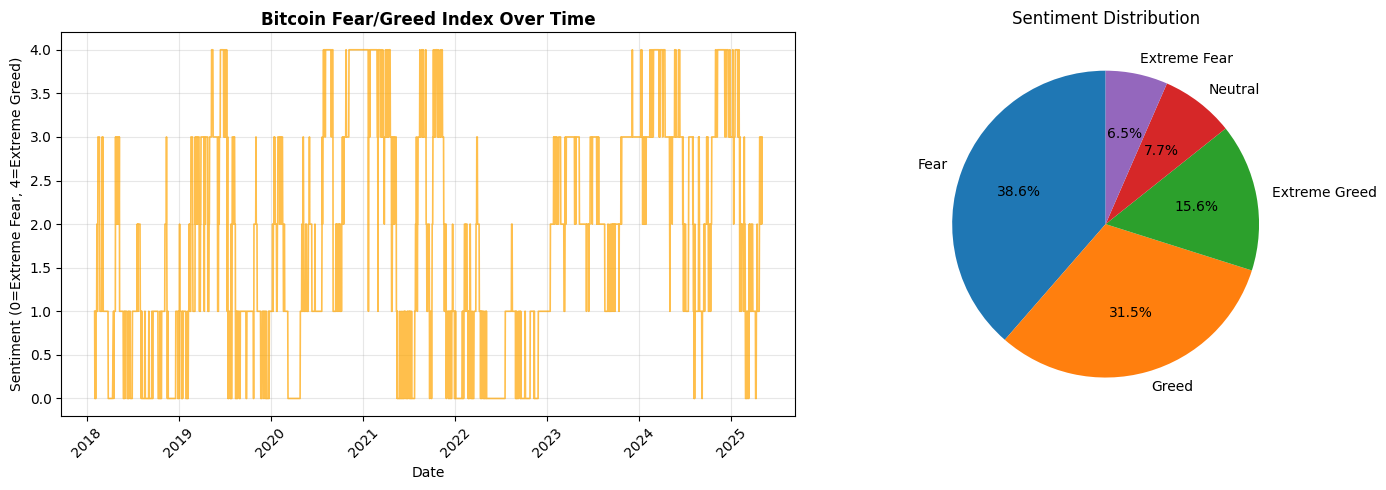

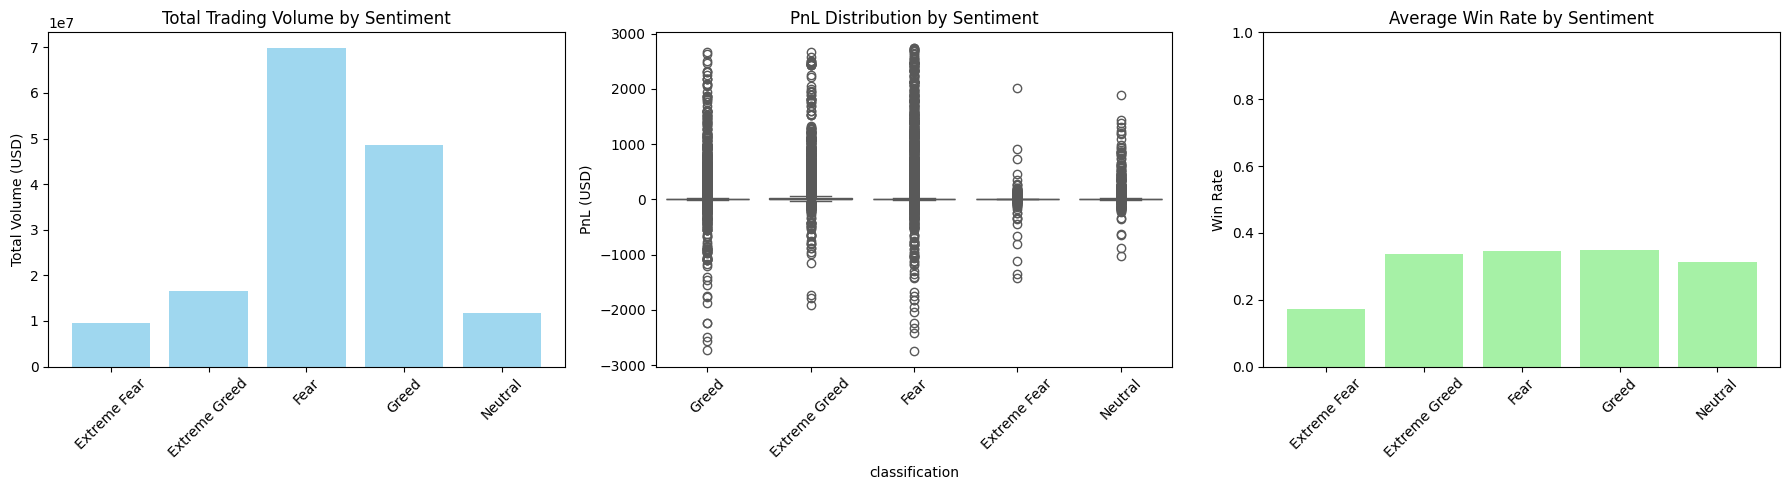

In [135]:
# =============================================================================
# 6. EDA VISUALIZATIONS
# =============================================================================
# 6.1 Sentiment over time + distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sentiment_plot = sentiment_daily.copy()
sentiment_plot['date'] = pd.to_datetime(sentiment_plot['date'])
plt.plot(sentiment_plot['date'], sentiment_plot['sentiment_numeric'], 
         alpha=0.7, linewidth=1.2, color='orange')
plt.title('Bitcoin Fear/Greed Index Over Time', fontsize=12, fontweight='bold')
plt.ylabel('Sentiment (0=Extreme Fear, 4=Extreme Greed)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sentiment_dist = merged['classification'].value_counts()
plt.pie(sentiment_dist.values, labels=sentiment_dist.index, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution')

plt.tight_layout()
plt.savefig('outputs/sentiment_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

# 6.2 Performance by sentiment
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
volume_by_sent = daily_agg.groupby('classification')['total_volume'].sum()
plt.bar(volume_by_sent.index, volume_by_sent.values, color='skyblue', alpha=0.8)
plt.title('Total Trading Volume by Sentiment')
plt.xticks(rotation=45)
plt.ylabel('Total Volume (USD)')

plt.subplot(1, 3, 2)
if 'closed_pnl' in merged.columns:
    sns.boxplot(data=merged, x='classification', y='closed_pnl', palette='Set2')
    plt.title('PnL Distribution by Sentiment')
    plt.xticks(rotation=45)
    plt.ylabel('PnL (USD)')

plt.subplot(1, 3, 3)
win_rate_by_sent = daily_agg.groupby('classification')['win_rate'].mean()
plt.bar(win_rate_by_sent.index, win_rate_by_sent.values, color='lightgreen', alpha=0.8)
plt.title('Average Win Rate by Sentiment')
plt.xticks(rotation=45)
plt.ylabel('Win Rate')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig('outputs/performance_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()


In [136]:
# =============================================================================
# 7. SUMMARY STATISTICS
# =============================================================================
summary_stats = daily_agg.groupby('classification')[['net_pnl', 'win_rate', 'trades_count']].agg(['mean', 'count']).round(4)
print(summary_stats)

                  net_pnl       win_rate       trades_count      
                     mean count     mean count         mean count
classification                                                   
Extreme Fear     133.3314    33   0.1735    33      70.4848    33
Extreme Greed   3391.9351   112   0.3356   112      49.4732   112
Fear            4321.7162   157   0.3443   157      87.3631   157
Greed           2024.4647   190   0.3483   190      58.9632   190
Neutral         1861.3997    37   0.3125    37      74.4324    37


In [137]:
# Publication-ready summary [web:17]
summary = daily_agg.groupby('classification').agg({
    'net_pnl': ['mean', 'count'],
    'win_rate': 'mean',
    'total_volume': 'sum'
}).round(4)

print("Key Trading Metrics by Sentiment:")
print(summary)
summary.to_csv('csv_files/executive_summary.csv')


Key Trading Metrics by Sentiment:
                  net_pnl       win_rate total_volume
                     mean count     mean          sum
classification                                       
Extreme Fear     133.3314    33   0.1735   9580240.04
Extreme Greed   3391.9351   112   0.3356  16475952.76
Fear            4321.7162   157   0.3443  69785656.94
Greed           2024.4647   190   0.3483  48556681.30
Neutral         1861.3997    37   0.3125  11762845.92
